In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed
from dataset import STDataset
from trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [ ]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_15min.csv'

In [ ]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [ ]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [ ]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = './datasets/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [69]:
# mini
df_test = pd.read_pickle('./datasets/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets/kannetsu_210402-220531.pkl')

In [70]:
dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [71]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_unspec_10d,minute_quarter,allCars,jam_quantity,search_15min,OCC,speed,year,datetime_id,section_id
0,2021-04-02,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,2156.0,0,223.0,0,8.0,0.03,86.421524,2021,8,31
1,2021-04-02,越後川口,堀之内,1800171,1800161,15,15,37.264629,37.251381,138.839630,...,798.0,0,17.0,0,0.0,0.00,89.411766,2021,8,2
2,2021-04-02,堀之内,小出,1800161,1800156,15,15,37.251381,37.213329,138.928635,...,786.0,0,14.0,0,1.0,0.00,90.285713,2021,8,3


### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [65]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [66]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets/kannetsu_210402-220531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [106]:
df_test_tr = pd.read_pickle('./datasets/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets/kannetsu_210402-210519.pkl')

dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [108]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_15min', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [112]:
X_tr, y_tr = format_stmatrix(df_all_tr, sec_table, feature_col, target_col)
X_va, y_va = format_stmatrix(df_all_va, sec_table, feature_col, target_col)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

torch.Size([5, 31968, 63]) torch.Size([5, 4608, 63]) torch.Size([1, 31968, 63]) torch.Size([1, 4608, 63])


In [3]:
# torch.save(X_tr, './datasets/features_train.pkl')
# torch.save(X_va, './datasets/features_test.pkl')
# torch.save(y_tr, './datasets/labels_train.pkl')
# torch.save(y_va, './datasets/labels_test.pkl')

# torch.save(X_tr, './datasets/mini_features_train.pkl')
# torch.save(X_va, './datasets/mini_features_test.pkl')
# torch.save(y_tr, './datasets/mini_labels_train.pkl')
# torch.save(y_va, './datasets/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [146]:
dt_table = pd.read_pickle('./datasets/datetime_table.pkl')
sec_table = pd.read_pickle('./datasets/section_table.pkl')

# X_tr = torch.load('./datasets/features_train.pkl')
# X_va = torch.load('./datasets/features_test.pkl')
# y_tr = torch.load('./datasets/labels_train.pkl')
# y_va = torch.load('./datasets/labels_test.pkl')

X_tr = torch.load('./datasets/mini_features_train.pkl')
X_va = torch.load('./datasets/mini_features_test.pkl')
y_tr = torch.load('./datasets/mini_labels_train.pkl')
y_va = torch.load('./datasets/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

torch.Size([5, 4608, 63]) torch.Size([5, 1152, 63])
torch.Size([1, 4608, 63]) torch.Size([1, 1152, 63])


In [147]:
# ID列は飛ばして標準化
skip_features = [0, 1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

torch.save(X_tr_norm, './datasets/mini_features_train_norm.pkl')
torch.save(X_va_norm, './datasets/mini_features_test_norm.pkl')

In [148]:
# test_ratio = 0.2
# X_train, X_val, y_train, y_val = train_test_split(X_norm, y, test_ratio)

# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}/labels_test.pkl')

# X_tr = torch.load(f'{config.MINI_DIR}/mini_features_train_norm.pkl')
# X_va = torch.load(f'{config.MINI_DIR}/mini_features_test_norm.pkl')
# y_tr = torch.load(f'{config.MINI_DIR}/mini_labels_train.pkl')
# y_va = torch.load(f'{config.MINI_DIR}/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 31968, 63]) torch.Size([5, 8832, 63])
torch.Size([1, 31968, 63]) torch.Size([1, 8832, 63])


In [5]:
time_step = 96
prediction_horizon = 1
space_window = (-2, 2)
static_col = config.STATIC_COL

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          prediction_horizon=prediction_horizon,
                          space_window=space_window, 
                          static_col=static_col)

## Networkの定義

### Embedding + Conv2d + LSTM

In [6]:
# normal
# EMB_DIM = 16
# CONV_DIM = 32 # 32->16
# LSTM_DIM = 64
# LSTM_LAYERS = 1
# SEARCH_CONV_DIM = 64 # 64->32
# SEARCH_FC_DIM = 32
# FC1_DIM = 32

# wide
# EMB_DIM = 16
# CONV_DIM = 64
# LSTM_DIM = 64
# LSTM_LAYERS = 1
# SEARCH_CONV_DIM = 64
# SEARCH_FC_DIM = 128
# FC1_DIM = 64

# wide2
EMB_DIM = 16
CONV_DIM = 64
LSTM_DIM = 128
LSTM_LAYERS = 2
SEARCH_CONV_DIM = 64
SEARCH_FC_DIM = 128
FC1_DIM = 64

In [7]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=LSTM_LAYERS, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, EMB_DIM)
        
        # traffic
        self.conv1 = nn.Conv2d(1, CONV_DIM, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(CONV_DIM, CONV_DIM, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(CONV_DIM, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(SEARCH_CONV_DIM, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(SEARCH_CONV_DIM * 96, SEARCH_FC_DIM)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + SEARCH_FC_DIM + EMB_DIM, FC1_DIM)
        self.fc2 = nn.Linear(FC1_DIM, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        out = F.relu(self.conv1(x_dy[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search
        s_out = F.relu(self.search_conv1(x_dy[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out
    

class NS_Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=LSTM_LAYERS, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, EMB_DIM)
        
        # traffic
        self.conv1 = nn.Conv2d(1, CONV_DIM, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(CONV_DIM, CONV_DIM, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(CONV_DIM, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        # self.search_conv1 = nn.Conv2d(2, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        # self.search_conv2 = nn.Conv2d(SEARCH_CONV_DIM, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        # self.search_fc = nn.Linear(SEARCH_CONV_DIM * 96, SEARCH_FC_DIM)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + EMB_DIM, FC1_DIM)
        self.fc2 = nn.Linear(FC1_DIM, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        out = F.relu(self.conv1(x_dy[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search
        # s_out = F.relu(self.search_conv1(x_dy[:, -3:-1]))
        # s_out = F.relu(self.search_conv2(s_out))
        # s_out = s_out.view(N, -1)
        # s_out = F.relu(self.search_fc(s_out))
        
        # linear
        # out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = torch.cat([h[0], cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

In [295]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, EMB_DIM)
        self.cat_bn = nn.BatchNorm1d(EMB_DIM)
        
        # traffic
        self.conv1 = nn.Conv2d(1, CONV_DIM, (9, 3), padding=self.padding)
        self.bn1 = nn.BatchNorm2d(CONV_DIM)
        self.conv2 = nn.Conv2d(CONV_DIM, CONV_DIM, (9, 3), padding=self.padding)
        self.bn2 = nn.BatchNorm2d(CONV_DIM)
        self.lstm = nn.LSTM(CONV_DIM, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_bn1 = nn.BatchNorm2d(SEARCH_CONV_DIM)
        self.search_conv2 = nn.Conv2d(SEARCH_CONV_DIM, SEARCH_CONV_DIM, (9, 3), padding=self.padding)
        self.search_bn2 = nn.BatchNorm2d(SEARCH_CONV_DIM)
        self.search_fc = nn.Linear(SEARCH_CONV_DIM * 96, SEARCH_FC_DIM)
        self.search_bn3 = nn.BatchNorm1d(SEARCH_FC_DIM)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + SEARCH_FC_DIM + EMB_DIM, FC1_DIM)
        self.bn3 = nn.BatchNorm1d(FC1_DIM)
        self.fc2 = nn.Linear(FC1_DIM, 1)
        
        # dropout
        self.embed_dropout = nn.Dropout(p=0.4)
        self.dropout = nn.Dropout(p=0.25)
        self.last_dropout = nn.Dropout(p=0.2)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_bn(self.cat_fc(cat_emb)))
        cat_out = self.embed_dropout(cat_out)
        
        # traffic
        out = F.relu(self.bn1(self.conv1(x_dy[:, -1:])))
        # out = self.dropout(out)
        out = F.relu(self.bn2(self.conv2(out)))
        # out = self.dropout(out)
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        h = self.dropout(h)
        
        # search
        s_out = F.relu(self.search_bn1(self.search_conv1(x_dy[:, -3:-1])))
        # s_out = self.dropout(s_out)
        s_out = F.relu(self.search_bn2(self.search_conv2(s_out)))
        # s_out = self.dropout(s_out)
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_bn3(self.search_fc(s_out)))
        s_out = self.dropout(s_out)
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.bn3(self.fc1(out)))
        out = self.last_dropout(out)
        out = self.fc2(out)
        
        return out

## 学習

In [16]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

### Embedding + Conv2d + LSTM

In [17]:
# hyper parameters
n_epochs = 20
hid_dim = LSTM_DIM
kernel_size = 5
num_layers = LSTM_LAYERS

# path
model_name = 'without_search/new_wide2_Embedding+Conv2d+LSTM'
log_path = f'./logs/{model_name}.log'
# model_name, log_path = None, None

# model
model = NS_Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [ ]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-08-29 07:31:07.540994 | Epoch: 1 | Train Loss: 26.471, Train Time: 89.89 [sec] | Valid Loss: 20.063, Valid Time: 14.34 [sec]
2022-08-29 07:32:51.727892 | Epoch: 2 | Train Loss: 14.922, Train Time: 89.86 [sec] | Valid Loss: 18.793, Valid Time: 14.32 [sec]
2022-08-29 07:34:35.882343 | Epoch: 3 | Train Loss: 14.558, Train Time: 89.82 [sec] | Valid Loss: 19.404, Valid Time: 14.33 [sec]
2022-08-29 07:36:19.935436 | Epoch: 4 | Train Loss: 14.335, Train Time: 89.72 [sec] | Valid Loss: 18.660, Valid Time: 14.34 [sec]
2022-08-29 07:38:03.900996 | Epoch: 5 | Train Loss: 14.177, Train Time: 89.64 [sec] | Valid Loss: 19.471, Valid Time: 14.32 [sec]
2022-08-29 07:39:47.859256 | Epoch: 6 | Train Loss: 14.036, Train Time: 89.64 [sec] | Valid Loss: 18.109, Valid Time: 14.32 [sec]
2022-08-29 07:41:31.578299 | Epoch: 7 | Train Loss: 13.934, Train Time: 89.39 [sec] | Valid Loss: 18.525, Valid Time: 14.32 [sec]
2022-08-29 07:43:15.376290 | Epoch: 8 | Train Loss: 13.843, Train Time: 89.45 [sec] | Vali

In [19]:
min(trainer.val_losses)

18.10919347031172

In [301]:
extra_epochs = 20

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

2022-08-16 14:36:11.520049 | Epoch: 51 | Train Loss: 19.004, Train Time: 139.69 [sec] | Valid Loss: 21.375, Valid Time: 13.80 [sec]
2022-08-16 14:38:44.323472 | Epoch: 52 | Train Loss: 19.048, Train Time: 138.99 [sec] | Valid Loss: 21.259, Valid Time: 13.80 [sec]
2022-08-16 14:41:15.897998 | Epoch: 53 | Train Loss: 18.957, Train Time: 137.76 [sec] | Valid Loss: 20.498, Valid Time: 13.81 [sec]
2022-08-16 14:43:47.366435 | Epoch: 54 | Train Loss: 18.909, Train Time: 137.63 [sec] | Valid Loss: 20.817, Valid Time: 13.83 [sec]
2022-08-16 14:46:19.140487 | Epoch: 55 | Train Loss: 18.868, Train Time: 137.93 [sec] | Valid Loss: 21.696, Valid Time: 13.85 [sec]
2022-08-16 14:48:49.756354 | Epoch: 56 | Train Loss: 18.878, Train Time: 136.78 [sec] | Valid Loss: 20.413, Valid Time: 13.83 [sec]
2022-08-16 14:51:20.727593 | Epoch: 57 | Train Loss: 18.879, Train Time: 137.07 [sec] | Valid Loss: 21.741, Valid Time: 13.89 [sec]
2022-08-16 14:56:24.235555 | Epoch: 59 | Train Loss: 18.788, Train Time: 137

### 学習曲線

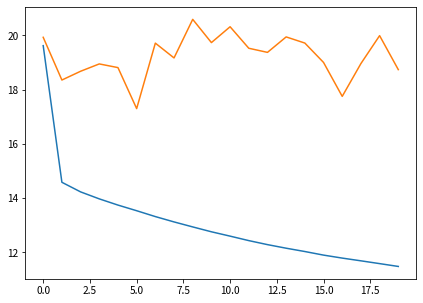

In [309]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [287]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

24.74691081010584
30.439557243391526


## 予測結果 可視化

In [20]:
model_name = 'wide2_Embedding+Conv2d+LSTM'

In [21]:
model = Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
model.load_state_dict(torch.load(f'{config.MODEL_DIR}/{model_name}_6.pth'))
model.eval()

Conv2dLSTM_Embedding(
  (dt_embed): Embedding(288, 32)
  (road_embed): Embedding(63, 16)
  (cat_fc): Linear(in_features=48, out_features=16, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (conv2): Conv2d(64, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (search_conv1): Conv2d(2, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (search_conv2): Conv2d(64, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (search_fc): Linear(in_features=6144, out_features=128, bias=True)
  (fc1): Linear(in_features=272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
model_ns = NS_Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
model_ns.load_state_dict(torch.load(f'{config.MODEL_DIR}/without_search/{model_name}_18.pth'))
model_ns.eval()

NS_Conv2dLSTM_Embedding(
  (dt_embed): Embedding(288, 32)
  (road_embed): Embedding(63, 16)
  (cat_fc): Linear(in_features=48, out_features=16, bias=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (conv2): Conv2d(64, 64, kernel_size=(9, 3), stride=(1, 1), padding=(4, 0))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (fc1): Linear(in_features=144, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [22]:
def pred_data_generator(X_test, y_test, time_step, prediction_horizon):
    def create(zero_date, pred_start_date, pred_window, sec_id):
        pred_start_ind = int((pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).total_seconds() / (60*15))
        pred_end_ind = pred_start_ind + pred_window

        in_start_ind = pred_start_ind - time_step
        in_end_ind = pred_end_ind - prediction_horizon + 1
        
        X_in = X_test[:, in_start_ind:in_end_ind, sec_id]
        y_in = y_test[:, in_start_ind:in_end_ind, sec_id]
        y_true = y_test[0, pred_start_ind:pred_end_ind, sec_id]
        
        return X_in, y_in, y_true
    return create

In [23]:
def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model(data).detach().cpu()

    return out

In [24]:
p_gen = pred_data_generator(X_va, y_va, time_step=time_step, prediction_horizon=prediction_horizon)
zero_date = '2022/3/1'

In [25]:
y_va.mean()

tensor(248.3687)

In [61]:
sec_table.query('end_name == "川越"')

,start_name,end_name,direction,KP
28,鶴ヶ島ＪＣＴ,川越,0,26.600000
34,三芳ＰＡ,川越,1,16.379999


### GW

In [62]:
pred_start_date = '2022/4/29'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [63]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

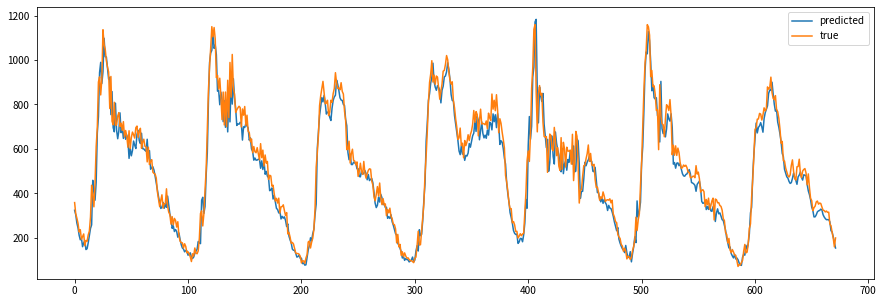

In [64]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

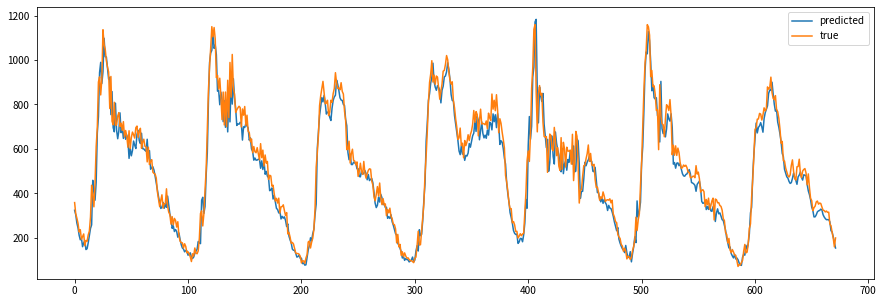

In [65]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out_ns)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

### 普通の1週間 (月~日)

#### 3月

In [40]:
pred_start_date = '2022/3/7'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [42]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

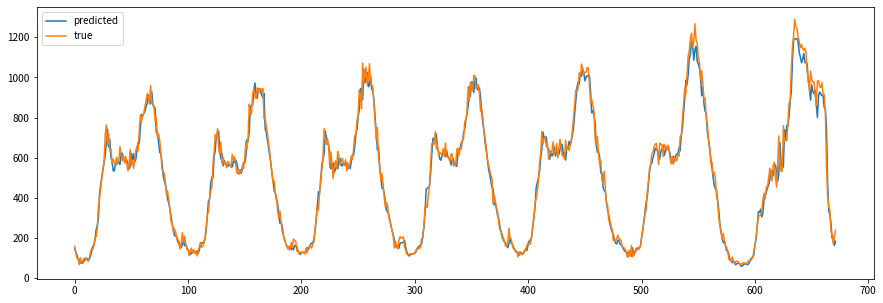

In [43]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

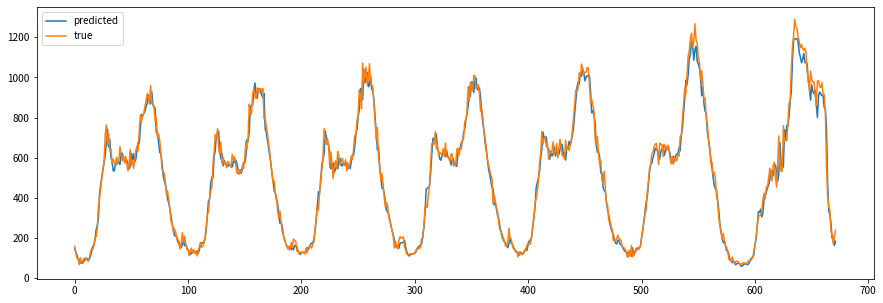

In [44]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out_ns)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 4月

In [45]:
pred_start_date = '2022/4/4'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [46]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

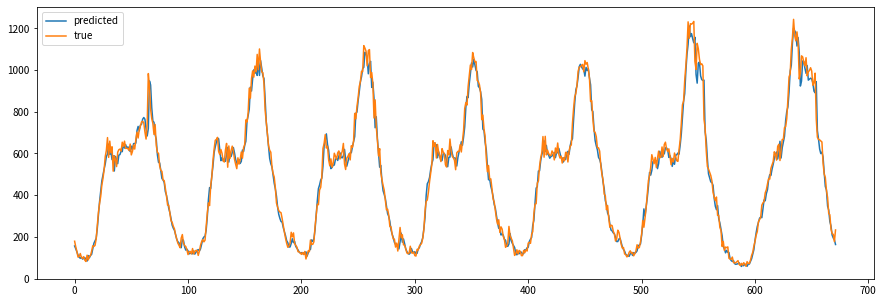

In [47]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

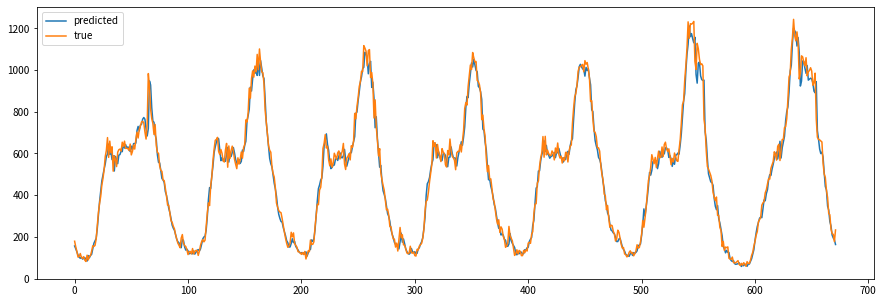

In [48]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out_ns)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 5月

In [236]:
pred_start_date = '2022/5/23'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [237]:
out = predict(model, dataset_test)

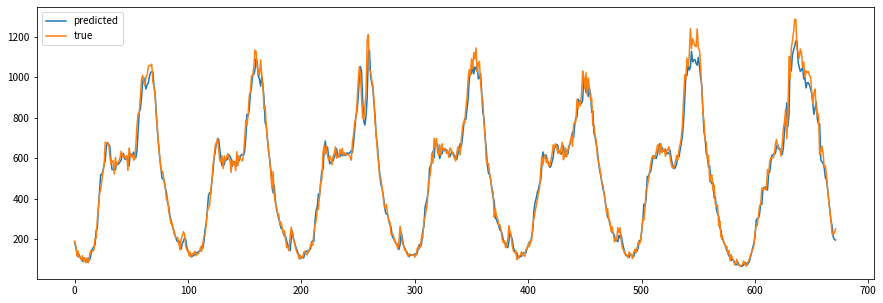

In [238]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

In [101]:
pred_start_date = '2022/5/3'
pred_window = 1 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [102]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

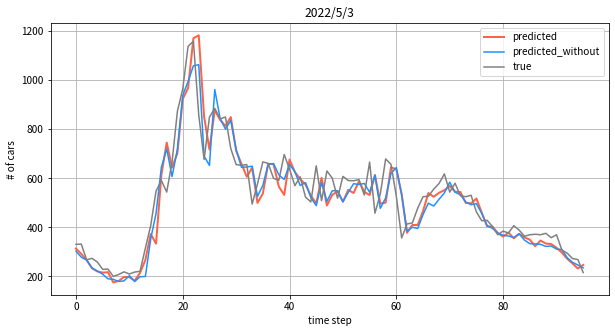

In [103]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(out_ns)), out_ns, label='predicted_without', color='dodgerblue')
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/3')
plt.legend()
plt.grid()
plt.show()

In [104]:
pred_start_date = '2022/5/14'
pred_window = 1 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [105]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

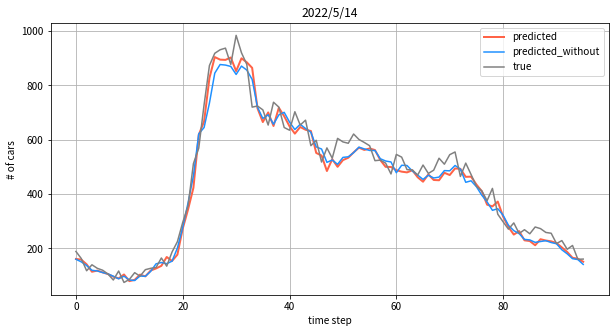

In [107]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(out_ns)), out_ns, label='predicted_without', color='dodgerblue')
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title('2022/5/14')
plt.legend()
plt.grid()
plt.show()

In [95]:
pred_start_date = '2022/5/11'
pred_window = 1 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[34])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [96]:
out = predict(model, dataset_test)
out_ns = predict(model_ns, dataset_test)

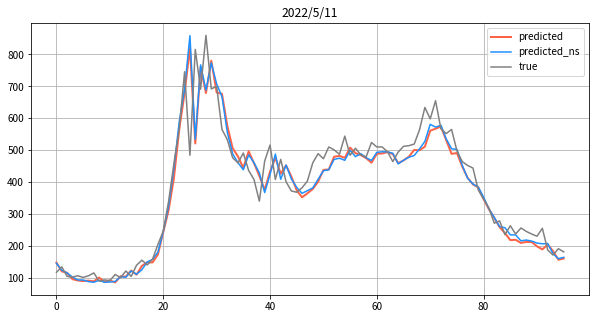

In [97]:
plt.figure(figsize=(10,5))
plt.plot(range(len(out)), out, label='predicted', color='tomato', lw=2)
plt.plot(range(len(out_ns)), out_ns, label='predicted_ns', color='dodgerblue')
plt.plot(range(len(y_true)), y_true, label='true', color='gray')
plt.title('2022/5/11')
plt.legend()
plt.grid()
plt.show()